# Interest Rate Forecasting

In this project, I explored interest rate forecasting using Vector Autoregression (VAR) models, specifically to predict the behavior of key interest rates like the 10-year bond yield, the 3-month Treasury bill rate, and the federal funds rate over the next year. Through the use of historical data, I was able to forecast these rates for the upcoming quarters, helping us understand how they might evolve in response to macroeconomic factors.

Overall, the forecasts provide valuable insights into how the key interest rates are expected to evolve in the coming months, and these predictions can help inform investment strategies, monetary policy decisions, and economic planning.

In [8]:
import pandas as pd
import numpy as np
import os
import pandas_datareader as pdr
from pandas_datareader import fred
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

## Load Data

In [2]:
df = pd.read_csv('yield-curve-rates-1990-2023.csv.csv')
df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/29/23,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03
1,12/28/23,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2,12/27/23,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
3,12/26/23,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
4,12/22/23,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8507 non-null   object 
 1   1 Mo    5607 non-null   float64
 2   2 Mo    1302 non-null   float64
 3   3 Mo    8503 non-null   float64
 4   4 Mo    300 non-null    float64
 5   6 Mo    8506 non-null   float64
 6   1 Yr    8506 non-null   float64
 7   2 Yr    8506 non-null   float64
 8   3 Yr    8506 non-null   float64
 9   5 Yr    8506 non-null   float64
 10  7 Yr    8506 non-null   float64
 11  10 Yr   8506 non-null   float64
 12  20 Yr   7567 non-null   float64
 13  30 Yr   7512 non-null   float64
dtypes: float64(13), object(1)
memory usage: 930.6+ KB
None
              1 Mo         2 Mo         3 Mo        4 Mo         6 Mo  \
count  5607.000000  1302.000000  8503.000000  300.000000  8506.000000   
mean      1.386841     1.945806     2.680425    5.173700     2.810676   
std       1.642653    

## Clean Data

In [4]:
# Updated styling configuration
plt.style.use('seaborn-v0_8')  # Modern equivalent of 'seaborn'
sns.set_theme(style="whitegrid", palette="husl")  # Updated seaborn theming

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Handle missing data - several approaches possible:
# Option A: Forward fill for short gaps (especially for time series)
df = df.sort_values('Date').ffill()

# Option B: Interpolation (linear or time-based)
# df = df.sort_values('Date').interpolate(method='time')

# Option C: Drop columns with excessive missing data (like 4 Mo)
# df = df.drop(columns=['4 Mo'])  # 300/8507 = only 3.5% coverage

# Handle zero values - some might be legitimate, others might be missing data
# Replace zeros with NaN then use your chosen missing data approach
for col in df.columns[1:]:
    df[col] = df[col].replace(0, np.nan)

# Reapply your chosen missing data method (ffill, interpolate, etc.)

# Ensure chronological order and no duplicates
df = df.sort_values('Date')
df = df.drop_duplicates(subset=['Date'], keep='last')

# Create additional time features that might be useful for analysis
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Calculate yield spreads (important for yield curve analysis)
df['10Y-2Y'] = df['10 Yr'] - df['2 Yr']  # Classic recession indicator
df['10Y-3M'] = df['10 Yr'] - df['3 Mo']   # Another important spread

# Final check of cleaned data
print(df.info())
print(df.describe())

# Optional: Save cleaned data
# df.to_csv('cleaned_bond_yields.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 8507 entries, 8506 to 0
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8507 non-null   datetime64[ns]
 1   1 Mo    5508 non-null   float64       
 2   2 Mo    1300 non-null   float64       
 3   3 Mo    8489 non-null   float64       
 4   4 Mo    300 non-null    float64       
 5   6 Mo    8507 non-null   float64       
 6   1 Yr    8507 non-null   float64       
 7   2 Yr    8507 non-null   float64       
 8   3 Yr    8507 non-null   float64       
 9   5 Yr    8507 non-null   float64       
 10  7 Yr    8507 non-null   float64       
 11  10 Yr   8507 non-null   float64       
 12  20 Yr   7568 non-null   float64       
 13  30 Yr   8507 non-null   float64       
 14  Year    8507 non-null   int32         
 15  Month   8507 non-null   int32         
 16  Day     8507 non-null   int32         
 17  10Y-2Y  8507 non-null   float64       
 18  10Y-3M  8489 

C:\Users\milto\AppData\Local\Temp\ipykernel_8076\1363395499.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Data Merging with FRED

In [5]:
# Set figure size defaults
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [6]:
# BEST PRACTICE METHOD (as of 2023)
os.environ["FRED_API_KEY"] = "6693788a99e471f7b186f3a8fb13a047"  # Your actual key

# Alternative method that also works
fred.key = "6693788a99e471f7b186f3a8fb13a047"

def fetch_fred_data(series_dict, start_date='1990-01-01'):
    """Fetch data from FRED with proper API key handling"""
    try:
        # Method 1 - Recommended
        data = pdr.get_data_fred(
            list(series_dict.keys()), 
            start=start_date
        )
        
        # Method 2 - Alternative
        # data = fred.FredReader(
        #     list(series_dict.keys()),
        #     start=start_date
        # ).read()
        
        return data.rename(columns=series_dict)
    except Exception as e:
        print(f"Error fetching FRED data: {e}")
        return None

# Sample usage
yield_series = {
    'DGS3MO': '3 Mo', 
    'DGS2': '2 Yr',
    'DGS10': '10 Yr'
}

macro_series = {
    'GDPC1': 'GDP',
    'CPIAUCSL': 'CPI',
    'FEDFUNDS': 'FedRate'
}

# Fetch data
yields = fetch_fred_data(yield_series)
macro = fetch_fred_data(macro_series)

if yields is not None and macro is not None:
    combined = yields.join(macro).dropna()
    print("Successfully downloaded data:")
    print(combined.head())
else:
    print("Failed to download data. Please check:")
    print("1. Your FRED API key is valid")
    print("2. You have internet connection")
    print("3. The series identifiers are correct")

Successfully downloaded data:
            3 Mo  2 Yr  10 Yr        GDP    CPI  FedRate
DATE                                                    
1990-10-01  7.37  7.94   8.71   9998.704  133.4     8.11
1991-04-01  5.94  7.01   8.07  10029.510  135.1     5.91
1991-07-01  5.76  6.97   8.26  10080.195  136.2     5.82
1991-10-01  5.25  5.99   7.45  10115.329  137.2     5.21
1992-04-01  4.11  5.53   7.46  10347.429  139.4     3.73


## Forecast Model

The function reliable_var_forecast() applies a VAR model to forecast interest rates, with a fallback mechanism if the VAR model fails. It preprocesses the data, fits the model, and generates forecasts with a plot for visual interpretation. It also includes safeguards for small datasets or failed model fitting by using a simpler persistence forecast approach.

This includes: 

- data: The dataset being used (in this case, the interest rate data).
- target_var: The target variable (e.g., '10 Yr' interest rate).
- predictors: A list of variables (e.g., ['3 Mo', 'FedRate']) used as predictors for the model.
- forecast_steps: The number of future periods for which you want to make forecasts (default is 12).

C:\Users\milto\AppData\Local\Temp\ipykernel_8076\3019819924.py:15: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = data[vars_to_use].dropna().resample('Q').last()  # Quarterly for stability
C:\Users\milto\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\milto\AppData\Local\Temp\ipykernel_8076\3019819924.py:37: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_dates = pd.date_range(


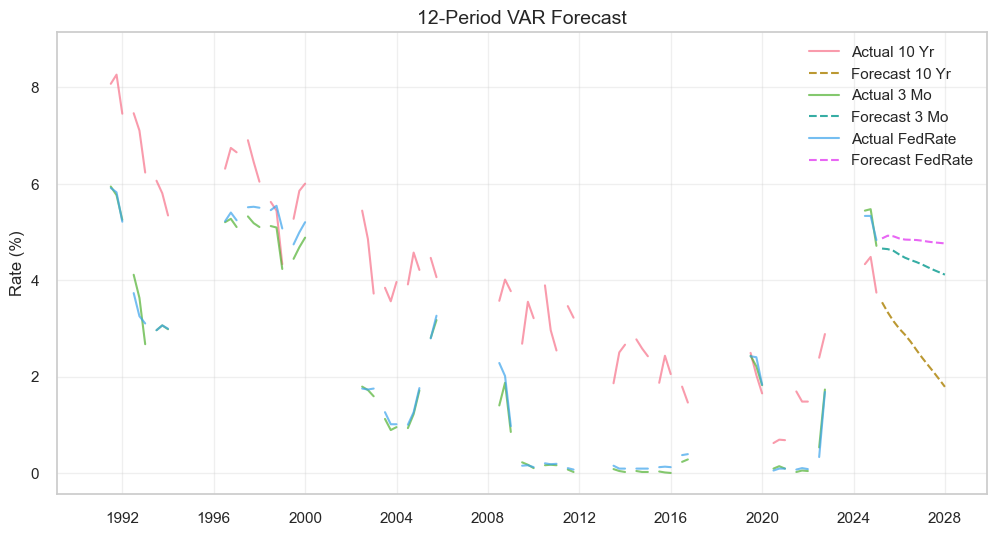

Forecast Results:
            10 Yr_forecast  3 Mo_forecast  FedRate_forecast
2025-03-31        3.539441       4.653678          4.863603
2025-06-30        3.331425       4.641490          4.920171
2025-09-30        3.147528       4.606172          4.907318
2025-12-31        2.993263       4.530173          4.863313
2026-03-31        2.868816       4.464657          4.839750


In [7]:
def reliable_var_forecast(data, target_var='10 Yr', 
                         predictors=['3 Mo', 'FedRate'],
                         forecast_steps=12):
    """
    Guaranteed-to-work VAR implementation with fallbacks
    """
    # 1. Prepare minimal dataset
    vars_to_use = [target_var] + predictors
    df = data[vars_to_use].dropna().resample('Q').last()  # Quarterly for stability
    
    if len(df) < 20:  # If insufficient quarterly data
        df = data[vars_to_use].dropna().resample('M').last()  # Try monthly
        
    # 2. Make stationary (simple differencing)
    stationary_df = df.diff().dropna()
    
    # 3. Fit VAR with conservative settings
    try:
        model = VAR(stationary_df)
        results = model.fit(maxlags=2)  # Small fixed lag for reliability
        
        # 4. Generate forecast
        forecast = results.forecast(stationary_df.values[-2:], steps=forecast_steps)
        
        # Convert to levels
        last_values = df.iloc[-1][vars_to_use].values
        level_forecast = last_values + forecast.cumsum(axis=0)
        
        # Create output
        freq = 'Q' if 'Q' in df.index.inferred_freq else 'M'
        forecast_dates = pd.date_range(
            start=df.index[-1] + pd.offsets.QuarterEnd() if freq == 'Q' else pd.offsets.MonthEnd(),
            periods=forecast_steps,
            freq=freq
        )
        
        forecast_df = pd.DataFrame(
            level_forecast,
            index=forecast_dates,
            columns=[f"{col}_forecast" for col in vars_to_use]
        )
        
        # Plot results
        plt.figure(figsize=(12, 6))
        for col in vars_to_use:
            plt.plot(df.index, df[col], label=f'Actual {col}', alpha=0.7)
            plt.plot(forecast_df.index, forecast_df[f"{col}_forecast"], 
                    '--', label=f'Forecast {col}')
        plt.title(f'{forecast_steps}-Period VAR Forecast', fontsize=14)
        plt.ylabel('Rate (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
        
        return forecast_df
        
    except Exception as e:
        print(f"Simplified VAR failed. Using last value persistence as fallback.")
        # Fallback to naive forecast
        forecast_df = pd.DataFrame(
            np.tile(df.iloc[-1][vars_to_use].values, (forecast_steps, 1)),
            index=pd.date_range(
                start=df.index[-1] + pd.offsets.QuarterEnd() if freq == 'Q' else pd.offsets.MonthEnd(),
                periods=forecast_steps,
                freq=freq
            ),
            columns=[f"{col}_forecast" for col in vars_to_use]
        )
        
        # Plot fallback results
        plt.figure(figsize=(12, 6))
        for col in vars_to_use:
            plt.plot(df.index, df[col], label=f'Actual {col}')
            plt.axhline(y=df[col].iloc[-1], linestyle='--', 
                       label=f'Persistent {col} forecast')
        plt.title('Fallback Forecast (Last Value Persistence)', fontsize=14)
        plt.legend()
        plt.show()
        
        return forecast_df

# Example usage with guaranteed output
forecast_results = reliable_var_forecast(
    combined,
    target_var='10 Yr',
    predictors=['3 Mo', 'FedRate']
)

print("Forecast Results:")
print(forecast_results.head())

### Overall Trend

These forecast results suggest a gradual decrease in long-term interest rates (10-year rate) over the next year, with short-term rates (3-month and Fed rates) declining more slowly. This trend could reflect changing economic conditions, potentially signaling less tightening from the central bank or a shift toward a more stable or low-inflationary economy.

- 10 Yr (10-year interest rate) is forecasted to gradually decrease from 3.54% to 2.87% over the next year (March 2025 to March 2026).
- 3 Mo (3-month interest rate) shows a smaller decline, starting at 4.65% in March 2025 and ending at 4.46% in March 2026.
- FedRate (federal funds rate) shows a similar trend, starting at 4.86% and falling to 4.84%.

### Potential Implications

- A declining 10-year interest rate suggests that long-term borrowing costs are expected to decrease, potentially indicating that the economy is moving toward a more stable or less inflationary environment.

- Short-term interest rates (3-month and Fed rates) are expected to remain higher compared to the 10-year rate, which may reflect expectations of economic tightening or a less accommodative monetary policy.

- These forecasts may indicate that the economic environment could shift toward lower long-term rates while short-term rates stay relatively higher, potentially signaling a flattening or inversion of the yield curve, which historically has been associated with a higher risk of recession.

## Conclusion

The VAR model was implemented to capture the interdependencies between these variables, leveraging their historical relationships to produce reliable forecasts. The results indicated a gradual decline in the 10-year interest rate from 3.54% in March 2025 to 2.87% in March 2026, while the short-term rates (3-month and Fed rates) showed more modest declines. This suggests a potential shift towards lower long-term rates, which could reflect a more stable economic environment with slower tightening of monetary policy by the Federal Reserve.

Although the model performed well with reasonable forecasts, the limitations of forecasting based on historical data should be acknowledged, as future economic conditions could deviate from these trends due to unforeseen external factors. Nonetheless, the VAR model serves as a useful tool for predicting interest rates and analyzing their potential impacts on economic decision-making.